# Extração de Features e Construção do Modelo

### 1. Introdução a Extração de Features
- A extração de features é uma parte muito importante na análise e na identificação de relações entre diferentes elementos. Como já sabemos, os dados de áudio não podem ser compreendidos diretamente pelos modelos, então precisamos convertê-los para um formato inteligível, e é para isso que a extração de features é utilizada.


#### Com a taxa de amostragem e os dados do sinal, podemos realizar diversas transformações para extrair características valiosas do áudio. No entanto, neste projeto, não vamos aprofundar no processo de seleção de features para identificar quais são mais relevantes para o nosso dataset. Em vez disso, vamos extrair cinco features principais para treinar nosso modelo:
- **Zero Crossing Rate (ZCR):** Mede a taxa de mudanças de sinal no áudio, ou seja, quantas vezes ele cruza o eixo zero em um determinado intervalo de tempo. Essa feature é útil para distinguir sons percussivos e não percussivos.
- **Chroma STFT:** Representa a energia espectral em 12 bins correspondentes às notas da escala musical ocidental. Essa característica é útil para identificar padrões harmônicos no áudio.
- **MFCC (Mel-Frequency Cepstral Coefficients):** Converte a frequência do áudio para a escala mel, aproximando-se da percepção auditiva humana. É uma das features mais utilizadas em reconhecimento de fala e emoção.
- **RMS (Root Mean Square):** Mede a energia do sinal ao calcular a média quadrática das amplitudes do áudio. Essa feature ajuda a representar a intensidade do som.
- **Mel Spectrogram:** Representa a distribuição de energia do áudio em diferentes faixas de frequência na escala mel, capturando informações espectrais essenciais.

### 1.1. Importando as bibliotecas

In [112]:
import pandas as pd
import numpy as np
import random

import pickle
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import joblib

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### 1.2. Carregar o Dataframe da EDA 

In [86]:
data_path = r"../data/ravdess_preprocessed.csv" 
df = pd.read_csv(data_path)

In [59]:
df

,Unnamed: 0,Emotions,Path,Processed_Path
0,0,neutral,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
1,1,neutral,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
2,2,neutral,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
3,3,neutral,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
4,4,calm,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
...,...,...,...,...
1435,1435,surprise,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
1436,1436,surprise,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
1437,1437,surprise,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...
1438,1438,surprise,C:\Users\duart\Downloads\Audio_Speech_Actors_0...,c:\Users\duart\OneDrive\Documentos\Trilha UFPB...


### 2. Criando uma função para extração das features

##### Fizemos essa parte no notebook passado, então você pode copiar e colar o código das funções aqui, pois precisaremos delas:

In [87]:
def noise(data):
    noise_amplitude = data.std()
    noise_data = np.random.normal(0, noise_amplitude, data.size)
    augmented_signal = data + noise_data
    return augmented_signal 

def stretch(data, rate=0.8):
    stretched_audio = librosa.effects.time_stretch(y=data, rate=rate)
    return stretched_audio 

def shift(data):
    shift_amount = random.random(1 * len(data))
    shifted_audio = np.roll(data, shift_amount)
    return shifted_audio 

def pitch(data, sampling_rate, pitch_factor=0.7):
    pitch_change = librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)
    return pitch_change 

# Tomando um áudio qualquer com exemplo
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

##### Aqui você deve extrair essas features de fato... mais tarde você precisará delas :)

In [88]:
def extract_features(data, sample_rate): 
    result = np.array([])
    # zcr
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data, pad=False), axis=1)
    result = np.hstack((result, zcr))

    # Chroma_stft
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate), axis=1)
    result = np.hstack((result, chroma_stft)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate), axis=1)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data, frame_length=2048, hop_length=512), axis=1)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr = sample_rate), axis=1)
    result = np.hstack((result, mel))
    
    return result

def get_features(path):
    # Carregar áudio
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Sem aumento de dados
    res1 = extract_features(data, sample_rate)  
    result = np.array(res1)

    # Com ruído
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)  
    result = np.vstack((result, res2))

    # Com alongamento e mudança de pitch
    new_data = stretch(data) 
    data_stretch_pitch = pitch(new_data, sample_rate) 
    res3 = extract_features(data_stretch_pitch, sample_rate) 
    result = np.vstack((result, res3)) 
    
    return result

##### Rode as células abaixo

In [89]:
X, Y = [], []
for path, emotion in zip(df['Path'], df['Emotions']):
    feature = get_features(path)
    # Appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [90]:
len(X), len(Y), df.Path.shape

(4320, 4320, (1440,))

##### Agora você deverá salvar o csv de features (features.csv)

In [91]:
# os.path.dirname() retorna o nome de um diretório
# os.getcwd() retorna o diretório pai 
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data") # acessa o diretório pai na pasta 'data'
os.makedirs(data_dir, exist_ok=True)

# armazena a informação de onde será salvo o CSV criado
csv_path = os.path.join(data_dir, "features.csv")

# Crie um DataFrame do pandas chamado Features usando a lista X.
features = pd.DataFrame(X)

# Transformando Y em um dataset com uma única coluna
labels = pd.DataFrame(Y, columns=['labels'])

# Concatenando o dataset labels a features
features = pd.concat([features, labels], axis=1)

# Salve o DataFrame como um arquivo CSV no caminho definido, sem incluir o índice, definindo _index_=False
features.to_csv(csv_path, index=False)


print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: c:\Users\duart\OneDrive\Documentos\Trilha UFPB 2025.2\Miniprojetos\miniprojeto2\data\features.csv


In [92]:
features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.577371,0.591136,0.492400,0.461673,0.500125,0.495526,0.515726,0.584809,0.624386,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116493e-06,8.190282e-06,0.000007,0.000005,4.245834e-07,neutral
1,0.409483,0.696543,0.737459,0.716377,0.675361,0.688551,0.643520,0.568759,0.615236,0.646371,...,1.416141e-03,1.533040e-03,1.485808e-03,1.595385e-03,1.513009e-03,1.448796e-03,0.001517,0.001438,1.484221e-03,neutral
2,0.188241,0.389092,0.457344,0.515946,0.423333,0.429246,0.495235,0.509360,0.539101,0.559584,...,8.576334e-07,9.576414e-07,7.733593e-07,5.233101e-07,3.593214e-07,9.264193e-07,0.000002,0.000001,7.753441e-08,neutral
3,0.293566,0.530008,0.564283,0.497886,0.427233,0.463398,0.497681,0.426065,0.489033,0.524762,...,6.984504e-06,7.034949e-06,6.654922e-06,6.979548e-06,1.214236e-05,9.640184e-06,0.000011,0.000006,4.254087e-07,neutral
4,0.408384,0.718975,0.721944,0.688609,0.673488,0.683200,0.580780,0.558377,0.600636,0.657417,...,1.734800e-03,1.678761e-03,1.719818e-03,1.771915e-03,1.858707e-03,1.841170e-03,0.001712,0.001760,1.801234e-03,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,0.414171,0.535965,0.568897,0.608863,0.613769,0.652480,0.691192,0.605035,0.559414,0.494037,...,5.476311e-02,5.898735e-02,5.748095e-02,5.562991e-02,5.684891e-02,5.740645e-02,0.057535,0.052600,4.802062e-02,surprise
4316,0.204272,0.387047,0.351958,0.399655,0.392837,0.347665,0.405136,0.457989,0.396946,0.324395,...,1.664630e-03,1.419731e-03,1.308418e-03,1.599555e-03,1.407549e-03,1.479881e-03,0.001353,0.000680,7.661307e-05,surprise
4317,0.219971,0.507571,0.460313,0.409703,0.414398,0.382926,0.417438,0.437294,0.486752,0.466801,...,5.655021e-03,4.140741e-03,3.525571e-03,2.786390e-03,2.527809e-03,2.580479e-03,0.002437,0.001115,9.113738e-05,surprise
4318,0.419153,0.608149,0.623523,0.640360,0.621674,0.633671,0.596322,0.584005,0.610167,0.605340,...,5.544840e-02,5.034181e-02,5.131820e-02,4.865410e-02,4.621587e-02,4.826154e-02,0.053640,0.048019,4.894923e-02,surprise


### 2.1. Data Preparation (Preparação dos Dados)

In [94]:
X = features.iloc[:, :-1].values
Y = features['labels'].values

In [95]:
# Use OneHotEncoder para transformar o Y em uma representação binária categórica, necessária para problemas de classificação multiclasse
Y = np.array(Y).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y)

In [96]:
# Use train_test_split do scikit-learn para dividir X e Y em conjuntos de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [97]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3240, 162) (3240, 8) (1080, 162) (1080, 8)


In [98]:
# Utilize StandardScaler do sklearn para normalizar as características de X
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [99]:
# Rode essa célula para deixar as dimensões certinhas com o modelo que iremos criar.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

### 3. Model Training (Modelling)

#### O modelo que vamos usar é uma rede neural convolucional (CNN) projetada para processar os dados extraídos dos arquivos de áudio. Essa estrutura é ideal para capturar padrões espectrais, como variações de tom e intensidade. A CNN é composta por:
- Camadas Convolucionais (Conv1D): Extraem características do espectro do áudio.
- Camadas de Pooling (MaxPooling1D): Reduzem a dimensionalidade e capturam as informações mais relevantes.
- Dropout: Ajuda a evitar overfitting.
- Camada Flatten: Transforma os mapas de features em um vetor de entrada para a camada totalmente conectada.
- Camadas Densas (Dense): Realizam a classificação final usando a função de ativação softmax.

In [100]:
# Dica: você pode olhar a documentação e ir seguindo o passo a passo arquitetônico para criar o modelo.

# Passo 1: Use Sequential() para criar o modelo como um contêiner linear.
model = Sequential()

# Passo 2: Adicione uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(162, 1)))

# Passo 3: Siga com uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Passo 4: Adicione mais uma camada Conv1D com 256 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))

# Passo 5: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Passo 6: Adicione mais uma camada Conv1D com 128 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))

# Passo 7: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Passo 8: Adicione uma camada Dropout com 0.2 de taxa de dropout.
model.add(Dropout(0.2))

# Passo 9: Adicione mais uma camada Conv1D com 64 filtros, kernel_size=5, strides=1, padding='same' e função de ativação 'relu'.
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))

# Passo 10: Adicione mais uma camada MaxPooling1D com pool_size=5, strides=2, padding='same'.
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# Passo 11: Adicione uma camada Flatten.
model.add(Flatten())

# Passo 12: Adicione uma camada Dense com 32 unidades e função de ativação 'relu'.
model.add(Dense(32, activation='relu'))

# Passo 13: Adicione uma camada Dropout com 0.3 de taxa de dropout.
model.add(Dropout(0.3))

# Passo 14: Adicione uma camada Dense com 8 unidades e função de ativação 'softmax'.
model.add(Dense(8, activation='softmax'))

# Passo 15: Compile o modelo com otimizador 'adam', loss 'categorical_crossentropy' e métrica 'accuracy'.
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

# Passo 16: Use model.summary() para visualizar o modelo.
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,288 (2.13 MB)

 Trainable params: 557,288 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### 3.1. Agora vamos de fato treinar o modelo, siga esses passos: 
##### 1. Use o callback para Ajustar a Taxa de Aprendizado 
##### ReduceLROnPlateau: Diminui a taxa de aprendizado quando uma métrica está estagnada.
   Parâmetros:
   - monitor='loss': Monitora a perda durante o treinamento.
   - factor=0.4: Reduz a taxa de aprendizado por este fator.
   - patience=2: Número de épocas sem melhora antes da redução.
   - min_lr=0.0000001: Limite mínimo para a taxa de aprendizado.
             
##### 2. Treine o Modelo 
##### Utilize model.fit para iniciar o treino da rede neural.
   Parâmetros:
   - x_train, y_train: Conjunto de dados de treino.
   - batch_size=64: Número de amostras por atualização de gradiente.
   - epochs=50: Número de vezes que o modelo treina em todo o conjunto de dados.
   - validation_data=(x_test, y_test): Conjunto de dados para validação durante o treino.
   - callbacks=[rlrp]: Lista de callbacks a serem aplicados durante o treino.
     

In [101]:
treinamento = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau()])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.1781 - loss: 2.0163 - val_accuracy: 0.2398 - val_loss: 1.9311 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2093 - loss: 1.9497 - val_accuracy: 0.2398 - val_loss: 1.8841 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2278 - loss: 1.9314 - val_accuracy: 0.2463 - val_loss: 1.8745 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2423 - loss: 1.8984 - val_accuracy: 0.2713 - val_loss: 1.8396 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2429 - loss: 1.8634 - val_accuracy: 0.2713 - val_loss: 1.8009 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2698 - loss: 1.8266 - val_accuracy: 0.3185 - val_loss: 1.7858 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3028 - loss: 1.7915 - val_acc

### 3.2. Avaliar e Visualizar a Performance do Modelo

##### Passo 1: Avaliando o Modelo
- **Precisão nos Dados de Teste**:
  - Use `model.evaluate(x_test, y_test)` para calcular a precisão do modelo no conjunto de teste.

##### Passo 2: Preparando os Gráficos
- **Definindo Épocas**:
  - Crie uma lista de épocas para o eixo x
- **Configurando o Layout do Gráfico**:
  - Use `fig, ax = plt.subplots(1, 2)` para criar dois gráficos lado a lado.

##### Passo 3: Plotando a Perda
- **Gráfico de Perda**:
  - Plote a perda de treino e teste:
    ```python
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ```

##### Passo 4: Plotando a Precisão
- **Gráfico de Precisão**:
  - Plote a precisão de treino e teste:
    ```python
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ```

##### Objetivos:
  - **Perda**: Ajuda a identificar se o modelo está treinando bem ou se há overfitting.
  - **Precisão**: Mostra o quão eficaz é o treinamento do modelo em acertar as previsões.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5917 - loss: 1.4457


<Figure size 1500x500 with 0 Axes>

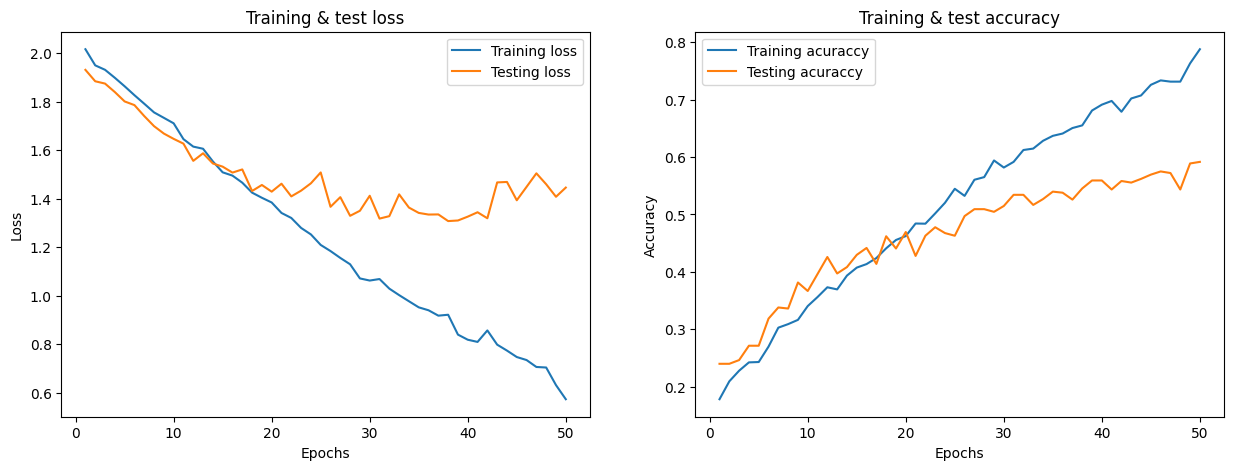

In [102]:
loss, accuracy = model.evaluate(x_test, y_test)

plt.figure(figsize=(15, 5))

epochs = list(range(1, 51))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# gráficos de perda
train_loss = treinamento.history['loss'] 
test_loss = treinamento.history['val_loss'] 

ax[0].plot(epochs, train_loss, label='Training loss')
ax[0].plot(epochs, test_loss, label='Testing loss')

ax[0].set_title('Training & test loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend() 


train_acc = treinamento.history['accuracy'] 
teste_acc = treinamento.history['val_accuracy'] 

ax[1].plot(epochs, train_acc, label='Training acuraccy')
ax[1].plot(epochs, teste_acc, label='Testing acuraccy')

ax[1].set_title('Training & test accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

### 3.3. Chegou a parte boa! vamos prever os valores nos dados de teste
- Passo 1: Use model.predict() no x_test e salve o resultado em pred_test.
- Passo 2: Crie y_pred a partir de pred_test usando inverse_transform do encoder (Precisamos converter as previsões codificadas do One-Hot de volta aos rótulos originais)
- Passo 3: Faça o mesmo para os rótulos de teste (y_test), decodificando-os de volta aos rótulos originais.

In [103]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [104]:
# Rode essa célula para ver se o modelo que criamos está fazendo sentido para a maioria dos valores.

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,disgust
1,surprise,surprise
2,fear,fear
3,fear,fear
4,disgust,disgust
5,angry,angry
6,disgust,sad
7,calm,calm
8,calm,calm
9,calm,sad


### 3.4. Plotar Matriz de Confusão
- Agora tenho um desafio para você, eu quero que você crie uma matriz de confusão que relacione os resultados preditos com os valores reais das emoções!

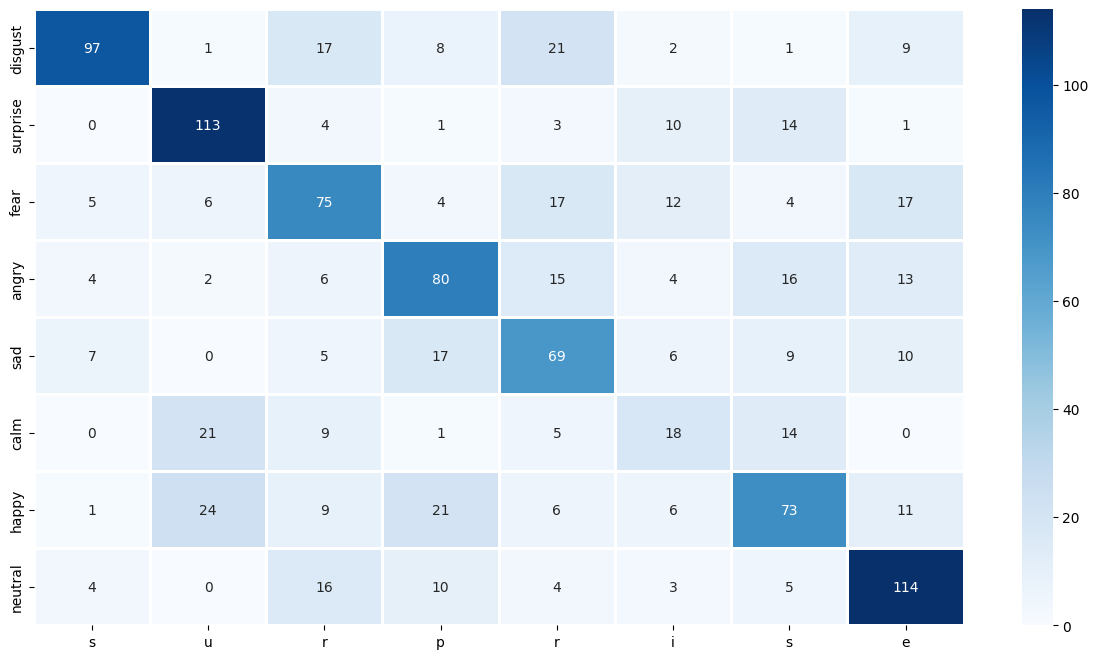

In [105]:
matriz_correlacao = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 8))

emotions = df['Actual Labels'].unique()

sns.heatmap(matriz_correlacao, cmap='Blues', annot=True, linewidths=1, xticklabels=emotion, yticklabels=emotions, fmt='d')
plt.show()

In [106]:
# Use a função classification_report do sklearn para visualizar a precisão, recall e f1-score do modelo.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.82      0.62      0.71       156
        calm       0.68      0.77      0.72       146
     disgust       0.53      0.54      0.53       140
        fear       0.56      0.57      0.57       140
       happy       0.49      0.56      0.52       123
     neutral       0.30      0.26      0.28        68
         sad       0.54      0.48      0.51       151
    surprise       0.65      0.73      0.69       156

    accuracy                           0.59      1080
   macro avg       0.57      0.57      0.57      1080
weighted avg       0.60      0.59      0.59      1080



### 4. Conclusão
- Podemos ver que nosso modelo é mais preciso na predição das emoções surpresa e raiva, o que faz sentido, pois os arquivos de áudio dessas emoções diferem bastante dos outros em aspectos como tom, velocidade, etc.
- No geral, alcançamos 62% de precisão nos dados de teste, o que é razoável, mas podemos melhorar ainda mais aplicando mais técnicas de aumento de dados e utilizando outros métodos de extração de features.

### 5. Salvando o Modelo e o Scaler

##### Passo 1: Salvando o Modelo
1. **Importação:** Use o `load_model` do Keras.
2. **Diretório:** Crie um diretório chamado `models` se não existir.
3. **Salvar:** Salve o modelo como no caminho especificado.

##### Passo 2: Salvando o Scaler
1. **Importação:** Use `joblib`.
2. **Diretório:** Utilize o mesmo caminho `models`.
3. **Salvar:** Salve o scaler.

In [111]:
directory_name = 'models'

try:
    os.makedirs(directory_name)
    print(f"Pasta '{directory_name}' criada com sucesso!")
except FileExistsError:
    print(f"Pasta {directory_name} já existe!")
except PermissionError:
    print(f"Acesso negada: Não foi possível criar a pasta {directory_name}.")
except Exception as e:
    print(f"Um erro ocorreu: {e}")


model_path = os.path.join(directory_name, 'modelo_sinistro.keras')

model.save(model_path)

print(f"Modelo salvo com sucesso em: {model_path}")

Pasta 'models' criada com sucesso!
Modelo salvo com sucesso em: models\modelo_sinistro.keras


In [115]:
scaler_path = os.path.join(directory_name, 'scaler_sinistro.save')
scaler_filename = scaler_path
joblib.dump(scaler, scaler_filename)

print(f'Scaler salvo com sucesso em: {scaler_path}')

Scaler salvo com sucesso em: models\scaler_sinistro.save
